# AutoMat

In [1]:
!pip install datasets piq matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 KB 13.4 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.9/106.9 KB 17.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 76.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 84.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 KB 53.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 89.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 KB 35.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 KB 38.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 KB 28.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.1/42.1 MB 60.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.1/111.1 KB 30.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 98.9 MB/s eta 0:00:00

## Dataset

In [22]:
from datasets import load_dataset

import gc
import piq
import torch
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader, random_split
from torchvision import transforms
from datasets import load_dataset
from PIL import Image
from torch.utils.data import DataLoader, Dataset

from piq import psnr, ssim, multi_scale_ssim

In [3]:
batch_size = 16
learning_rate = 1e-3
num_epochs = 50
latent_dim = 128

In [4]:
class TexturesDataset(Dataset):
    def __init__(self, split="train"):
        raw_dataset = load_dataset(
            "dream-textures/textures-color-normal-1k", split=split
        )
        self.valid_samples = []

        for i in range(len(raw_dataset)):
            if i == 465:
                continue

            sample = raw_dataset[i]

            color, normal = sample["color"], sample["normal"]
            if (
                isinstance(color, Image.Image)
                and color.mode == "RGB"
                and isinstance(normal, Image.Image)
                and normal.mode == "RGB"
            ):
                self.valid_samples.append(sample)
            else:
                print(
                    f"Skipping sample {i}: invalid mode. Color: {getattr(color, 'mode', None)}, Normal: {getattr(normal, 'mode', None)}"
                )

        print(
            f"Loaded {len(self.valid_samples)} valid RGB samples out of {len(raw_dataset)}."
        )

        self.transform = transforms.Compose(
            [transforms.Resize((512, 512)), transforms.ToTensor()]
        )

    def __len__(self):
        return len(self.valid_samples)

    def __getitem__(self, idx):
        sample = self.valid_samples[idx]
        color = self.transform(sample["color"])
        normal = self.transform(sample["normal"])
        return torch.cat((color, normal), dim=0)

In [5]:
dataset = TexturesDataset()


train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(
    dataset, [train_size, test_size], generator=torch.Generator().manual_seed(42)
)

README.md:   0%|          | 0.00/2.72k [00:00<?, ?B/s]

(…)-00000-of-00001-7d3033d434a1d73a.parquet:   0%|          | 0.00/111M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1426 [00:00<?, ? examples/s]

Skipping sample 35: invalid mode. Color: L, Normal: RGB
Skipping sample 155: invalid mode. Color: L, Normal: RGB
Skipping sample 300: invalid mode. Color: L, Normal: RGB
Skipping sample 366: invalid mode. Color: L, Normal: RGB
Skipping sample 495: invalid mode. Color: L, Normal: RGB
Skipping sample 713: invalid mode. Color: L, Normal: RGB
Skipping sample 728: invalid mode. Color: L, Normal: RGB
Skipping sample 734: invalid mode. Color: L, Normal: RGB
Skipping sample 791: invalid mode. Color: L, Normal: RGB
Skipping sample 805: invalid mode. Color: L, Normal: RGB
Skipping sample 847: invalid mode. Color: L, Normal: RGB
Skipping sample 863: invalid mode. Color: L, Normal: RGB
Skipping sample 879: invalid mode. Color: L, Normal: RGB
Skipping sample 1056: invalid mode. Color: L, Normal: RGB
Skipping sample 1090: invalid mode. Color: L, Normal: RGB
Skipping sample 1227: invalid mode. Color: L, Normal: RGB
Skipping sample 1262: invalid mode. Color: L, Normal: RGB
Skipping sample 1331: invali

In [6]:
train_dataset[0].shape

torch.Size([6, 512, 512])

In [7]:
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
)
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
)

In [8]:
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(6, 64, 4, stride=2, padding=1),   # -> (64, 256, 256)
            nn.ReLU(),
            nn.Conv2d(64, 128, 4, stride=2, padding=1),  # -> (128, 128, 128)
            nn.ReLU(),
            nn.Conv2d(128, 256, 4, stride=2, padding=1), # -> (256, 64, 64)
            nn.ReLU(),
            #nn.Conv2d(256, 512, 4, stride=2, padding=1), # -> (512, 32, 32)
            #nn.ReLU(),
            nn.Flatten(),
            nn.Linear(256 * 64 * 64, latent_dim) # use product of last used conv2d layer
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256 * 64 * 64), #nn.Linear(latent_dim, 512 * 32 * 32),
            nn.ReLU(),
            nn.Unflatten(1, (256, 64, 64)),#nn.Unflatten(1, (512, 32, 32)),
            #nn.ConvTranspose2d(512, 256, 4, stride=2, padding=1),  # -> (256, 64, 64)
            #nn.ReLU(),
            nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1),  # -> (128, 128, 128)
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),   # -> (64, 256, 256)
            nn.ReLU(),
            nn.ConvTranspose2d(64, 6, 4, stride=2, padding=1),
            nn.Sigmoid()  # For pixel values in [0,1]
        )

    def forward(self, x):
        z = self.encoder(x)
        out = self.decoder(z)
        return out

## Training

In [57]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model = ConvAutoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

Using device: cuda


In [58]:
loss_values = []

for epoch in range(num_epochs):
    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        output = model(data)        
        loss = criterion(output, data)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    average_loss = total_loss / len(train_loader)
    loss_values.append(average_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {average_loss:.4f}")

Epoch [1/50], Loss: 0.0285
Epoch [2/50], Loss: 0.0201
Epoch [3/50], Loss: 0.0172
Epoch [4/50], Loss: 0.0135
Epoch [5/50], Loss: 0.0110
Epoch [6/50], Loss: 0.0099
Epoch [7/50], Loss: 0.0102
Epoch [8/50], Loss: 0.0090
Epoch [9/50], Loss: 0.0087
Epoch [10/50], Loss: 0.0086
Epoch [11/50], Loss: 0.0084
Epoch [12/50], Loss: 0.0082
Epoch [13/50], Loss: 0.0082
Epoch [14/50], Loss: 0.0077
Epoch [15/50], Loss: 0.0075
Epoch [16/50], Loss: 0.0074
Epoch [17/50], Loss: 0.0073
Epoch [18/50], Loss: 0.0072
Epoch [19/50], Loss: 0.0070
Epoch [20/50], Loss: 0.0080
Epoch [21/50], Loss: 0.0069
Epoch [22/50], Loss: 0.0068
Epoch [23/50], Loss: 0.0065
Epoch [24/50], Loss: 0.0065
Epoch [25/50], Loss: 0.0065
Epoch [26/50], Loss: 0.0064
Epoch [27/50], Loss: 0.0064
Epoch [28/50], Loss: 0.0064
Epoch [29/50], Loss: 0.0061
Epoch [30/50], Loss: 0.0060
Epoch [31/50], Loss: 0.0061
Epoch [32/50], Loss: 0.0058
Epoch [33/50], Loss: 0.0058
Epoch [34/50], Loss: 0.0056
Epoch [35/50], Loss: 0.0057
Epoch [36/50], Loss: 0.0056
E

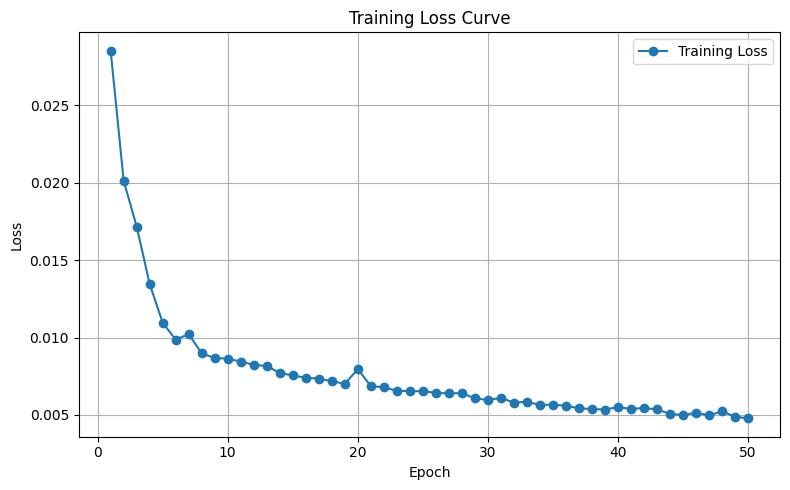

In [59]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, num_epochs + 1), loss_values, marker='o', label='Training Loss')
plt.title('Training Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

## Inference

In [60]:
def evaluate(model):
    model.eval()
    total_psnr = 0
    total_ssim = 0
    total_mse = 0
    total_ms_ssim = 0
    num_samples = 0

    with torch.no_grad():
        for data in test_loader:
            data = data.to(device)
            output = model(data)

            psnr_value = psnr(output, data)
            ssim_value = ssim(output, data, data_range=1.0)
            mse_value = nn.MSELoss()(output, data)
            ms_ssim_value = multi_scale_ssim(output, data, data_range=1.0)

            total_psnr += psnr_value.item()
            total_ssim += ssim_value.item()
            total_mse += mse_value.item()
            total_ms_ssim += ms_ssim_value.item()
            num_samples += 1

    avg_psnr = total_psnr / num_samples
    avg_ssim = total_ssim / num_samples
    avg_mse = total_mse / num_samples
    avg_ms_ssim = total_ms_ssim / num_samples

    print(f"Test Metrics:")
    print(f"Average PSNR: {avg_psnr:.4f}")
    print(f"Average SSIM: {avg_ssim:.4f}")
    print(f"Average MSE: {avg_mse:.4f}")
    print(f"Average MS-SSIM: {avg_ms_ssim:.4f}")

    return {
        "psnr": avg_psnr,
        "ssim": avg_ssim,
        "mse": avg_mse,
        "ms_ssim": avg_ms_ssim
    }


In [61]:
evaluate(model)

Test Metrics:
Average PSNR: 24.3536
Average SSIM: 0.5855
Average MSE: 0.0066
Average MS-SSIM: 0.6287


{'psnr': 24.35355546739366,
 'ssim': 0.5855218900574578,
 'mse': 0.006614670183302628,
 'ms_ssim': 0.6286522481176589}

## Loss Functions

In [32]:
def get_loss_function(name="mse"):
    if name == "mse":
        return lambda x, y: nn.functional.mse_loss(x, y)
    elif name == "l1":
        return lambda x, y: nn.functional.l1_loss(x, y)
    elif name == "ssim":
        return lambda x, y: 1 - piq.ssim(x, y, data_range=1.0)
    elif name == "ms-ssim":
        return lambda x, y: 1 - piq.multi_scale_ssim(x, y, data_range=1.0)
    else:
        raise ValueError(f"Unknown loss function: {name}")


In [ ]:
loss_functions = ["mse", "l1", "ssim", "ms-ssim"]

for loss_name in loss_functions:
    print(f"\nTraining with {loss_name.upper()} loss\n" + "-" * 40)

    model = ConvAutoencoder(latent_dim=latent_dim).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = get_loss_function(loss_name)

    for epoch in range(5):
        total_loss = 0
        for data in train_loader:
            data = data.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, data)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch [{epoch+1}/5], Loss: {total_loss / len(train_loader):.4f}")

    evaluate(model)
    
    del model, optimizer
    torch.cuda.empty_cache()
    gc.collect()


Training with MSE loss
----------------------------------------
Epoch [1/5], Loss: 0.0156
Epoch [2/5], Loss: 0.0050
Epoch [3/5], Loss: 0.0037
Epoch [4/5], Loss: 0.0032
Epoch [5/5], Loss: 0.0030
Test Metrics:
Average PSNR: 26.6345
Average SSIM: 0.8283
Average MSE: 0.0030
Average MS-SSIM: 0.8847

Training with L1 loss
----------------------------------------
Epoch [1/5], Loss: 0.0871
Epoch [2/5], Loss: 0.0478
Epoch [3/5], Loss: 0.0407
Epoch [4/5], Loss: 0.0387
Epoch [5/5], Loss: 0.0368
Test Metrics:
Average PSNR: 26.9646
Average SSIM: 0.7852
Average MSE: 0.0034
Average MS-SSIM: 0.8427

Training with SSIM loss
----------------------------------------
Epoch [1/5], Loss: 0.2942
Epoch [2/5], Loss: 0.0798
Epoch [3/5], Loss: 0.0433
Epoch [4/5], Loss: 0.0313
Epoch [5/5], Loss: 0.0271
Test Metrics:
Average PSNR: 20.3198
Average SSIM: 0.9796
Average MSE: 0.0095
Average MS-SSIM: 0.9464

Training with MS-SSIM loss
----------------------------------------
Epoch [1/5], Loss: 0.2179
Epoch [2/5], Loss

# Hybrid Loss Function


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model = ConvAutoencoder().to(device)
mse_loss = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
alpha = 0.2

Using device: cuda


In [14]:
for epoch in range(num_epochs):
    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        output = model(data)

        mse = mse_loss(output, data)
        ms_ssim_loss = 1 - multi_scale_ssim(output, data, data_range=1.0, reduction="mean")
        loss = alpha * mse + (1 - alpha) * ms_ssim_loss
        
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss / len(train_loader):.4f}")

Epoch [1/50], Loss: 0.1751
Epoch [2/50], Loss: 0.0610
Epoch [3/50], Loss: 0.0486
Epoch [4/50], Loss: 0.0318
Epoch [5/50], Loss: 0.0252
Epoch [6/50], Loss: 0.0203
Epoch [7/50], Loss: 0.0165
Epoch [8/50], Loss: 0.0142
Epoch [9/50], Loss: 0.0131
Epoch [10/50], Loss: 0.0126
Epoch [11/50], Loss: 0.0119
Epoch [12/50], Loss: 0.0111
Epoch [13/50], Loss: 0.0107
Epoch [14/50], Loss: 0.0106
Epoch [15/50], Loss: 0.0102
Epoch [16/50], Loss: 0.0099
Epoch [17/50], Loss: 0.0101
Epoch [18/50], Loss: 0.0092
Epoch [19/50], Loss: 0.0091
Epoch [20/50], Loss: 0.0088
Epoch [21/50], Loss: 0.0086
Epoch [22/50], Loss: 0.0083
Epoch [23/50], Loss: 0.0083
Epoch [24/50], Loss: 0.0081
Epoch [25/50], Loss: 0.0078
Epoch [26/50], Loss: 0.0080
Epoch [27/50], Loss: 0.0073
Epoch [28/50], Loss: 0.0075
Epoch [29/50], Loss: 0.0071
Epoch [30/50], Loss: 0.0070
Epoch [31/50], Loss: 0.0069
Epoch [32/50], Loss: 0.0071
Epoch [33/50], Loss: 0.0066
Epoch [34/50], Loss: 0.0068
Epoch [35/50], Loss: 0.0065
Epoch [36/50], Loss: 0.0065
E

In [15]:
evaluate(model)

Test Metrics:
Average PSNR: 26.7770
Average SSIM: 0.9875
Average MSE: 0.0022
Average MS-SSIM: 0.9938


In [20]:
import gc

# del x, optimizer
torch.cuda.empty_cache()
gc.collect()

2812

# Weighted Combination of Loss Functions

In [20]:
batch_size = 16
learning_rate = 1e-3
num_epochs = 50
latent_dim = 128

In [17]:
def get_weighted_loss(weights):
    def loss_fn(x, y):
        mse_loss = nn.functional.mse_loss(x, y)
        l1_loss = nn.functional.l1_loss(x, y)
        ssim_loss = 1 - piq.ssim(x, y, data_range=1.0)
        ms_ssim_loss = 1 - piq.multi_scale_ssim(x, y, data_range=1.0)
        return (weights[0] * mse_loss +
                weights[1] * l1_loss +
                weights[2] * ssim_loss +
                weights[3] * ms_ssim_loss)
    return loss_fn
    

In [18]:
def compute_metric_score(metrics, weights=(1, 1, 1, 1)):
    # Higher PSNR, SSIM, MS-SSIM are better → maximize
    # Lower MSE is better → minimize, so we negate or invert it
    # You can normalize them based on typical ranges if needed

    # Sample normalization — scale values to [0, 1] range
    psnr_score = metrics["psnr"] / 50           # assuming 50 is max expected PSNR
    ssim_score = metrics["ssim"]                # already in [0,1]
    ms_ssim_score = metrics["ms_ssim"]          # already in [0,1]
    mse_score = 1 - (metrics["mse"] / 0.1)      # assuming 0.1 is worst-case MSE

    mse_score = max(0, min(1, mse_score))

    final_score = (
        weights[0] * psnr_score +
        weights[1] * ssim_score +
        weights[2] * ms_ssim_score +
        weights[3] * mse_score
    ) / sum(weights)

    return final_score


In [28]:
from itertools import product
import numpy as np

weight_options = np.linspace(0, 1, 5)
loss_weight_sets = [w for w in product(weight_options, repeat=4) if np.isclose(sum(w), 1.0)]

best_score = -float("inf")
best_weights = None

for weights in loss_weight_sets:
    print(f"\nTraining with loss weights: {weights}")
    model = ConvAutoencoder().to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = get_weighted_loss(weights)

    for epoch in range(10):
        total_loss = 0
        for data in train_loader:
            data = data.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, data)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch [{epoch+1}/10], Loss: {total_loss / len(train_loader):.4f}")

    # Evaluate the model
    print("Evaluating...")
    metrics = evaluate(model)

    score = compute_metric_score(metrics)
    print(f"Combined Metric Score: {score:.4f}")

    if score > best_score:
        best_score = score
        best_weights = weights
        print(f"New best weights: {best_weights} -> Score: {score:.4f}")

    del model, optimizer
    torch.cuda.empty_cache()
    gc.collect()

print(f"\nBest loss weights: {best_weights} with score: {best_score:.4f}")



Training with loss weights: (np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(1.0))
Epoch [1/10], Loss: 0.4090
Epoch [2/10], Loss: 0.4041
Epoch [3/10], Loss: 0.3999
Epoch [4/10], Loss: 0.3998
Epoch [5/10], Loss: 0.4045
Epoch [6/10], Loss: 0.4004
Epoch [7/10], Loss: 0.3984
Epoch [8/10], Loss: 0.3991
Epoch [9/10], Loss: 0.3950
Epoch [10/10], Loss: 0.3984
Evaluating...
Test Metrics:
Average PSNR: 16.5129
Average SSIM: 0.5552
Average MSE: 0.0315
Average MS-SSIM: 0.6141
Combined Metric Score: 0.5461
New best weights: (np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(1.0)) -> Score: 0.5461

Training with loss weights: (np.float64(0.0), np.float64(0.0), np.float64(0.25), np.float64(0.75))
Epoch [1/10], Loss: 0.4244
Epoch [2/10], Loss: 0.4190
Epoch [3/10], Loss: 0.4140
Epoch [4/10], Loss: 0.4137
Epoch [5/10], Loss: 0.4125
Epoch [6/10], Loss: 0.4129
Epoch [7/10], Loss: 0.4115
Epoch [8/10], Loss: 0.4124
Epoch [9/10], Loss: 0.4112
Epoch [10/10], Loss: 0.4096
Evaluating.

# Training with Best Combination of Weights

In [48]:
weights = (0.20, 0.75, 0.0, 0.05)
model = ConvAutoencoder().to(device)
criterion = get_weighted_loss(weights)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [49]:
loss_history = {
    "total": [],
    "mse": [],
    "l1": [],
    "ssim": [],
    "ms_ssim": []
}

for epoch in range(num_epochs):
    total_loss = 0
    total_mse = 0
    total_l1 = 0
    total_ssim = 0
    total_ms_ssim = 0

    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        output = model(data)

        # Individual losses
        mse_loss = nn.functional.mse_loss(output, data)
        l1_loss = nn.functional.l1_loss(output, data)
        ssim_loss = 1 - piq.ssim(output, data, data_range=1.0)
        ms_ssim_loss = 1 - piq.multi_scale_ssim(output, data, data_range=1.0)

        # Weighted loss
        loss = criterion(output, data)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_mse += mse_loss.item()
        total_l1 += l1_loss.item()
        total_ssim += ssim_loss.item()
        total_ms_ssim += ms_ssim_loss.item()

    # Store epoch-wise averages
    n = len(train_loader)
    loss_history["total"].append(total_loss / n)
    loss_history["mse"].append(total_mse / n)
    loss_history["l1"].append(total_l1 / n)
    loss_history["ssim"].append(total_ssim / n)
    loss_history["ms_ssim"].append(total_ms_ssim / n)

    print(f"Epoch [{epoch+1}/{num_epochs}], Total Loss: {total_loss / n:.4f}, "
          f"MSE: {total_mse / n:.4f}, L1: {total_l1 / n:.4f}, "
          f"SSIM: {total_ssim / n:.4f}, MS-SSIM: {total_ms_ssim / n:.4f}")


Epoch [1/50], Total Loss: 0.1098, MSE: 0.0275, L1: 0.1106, SSIM: 0.4858, MS-SSIM: 0.4262
Epoch [2/50], Total Loss: 0.0930, MSE: 0.0201, L1: 0.0913, SSIM: 0.4504, MS-SSIM: 0.4107
Epoch [3/50], Total Loss: 0.0782, MSE: 0.0135, L1: 0.0735, SSIM: 0.4424, MS-SSIM: 0.4081
Epoch [4/50], Total Loss: 0.0734, MSE: 0.0118, L1: 0.0680, SSIM: 0.4361, MS-SSIM: 0.4019
Epoch [5/50], Total Loss: 0.0723, MSE: 0.0115, L1: 0.0667, SSIM: 0.4332, MS-SSIM: 0.3989
Epoch [6/50], Total Loss: 0.0719, MSE: 0.0115, L1: 0.0663, SSIM: 0.4329, MS-SSIM: 0.3968
Epoch [7/50], Total Loss: 0.0694, MSE: 0.0104, L1: 0.0631, SSIM: 0.4329, MS-SSIM: 0.3997
Epoch [8/50], Total Loss: 0.0671, MSE: 0.0097, L1: 0.0605, SSIM: 0.4303, MS-SSIM: 0.3966
Epoch [9/50], Total Loss: 0.0667, MSE: 0.0095, L1: 0.0599, SSIM: 0.4320, MS-SSIM: 0.3980
Epoch [10/50], Total Loss: 0.0675, MSE: 0.0098, L1: 0.0610, SSIM: 0.4293, MS-SSIM: 0.3945
Epoch [11/50], Total Loss: 0.0656, MSE: 0.0093, L1: 0.0589, SSIM: 0.4263, MS-SSIM: 0.3913
Epoch [12/50], Tota

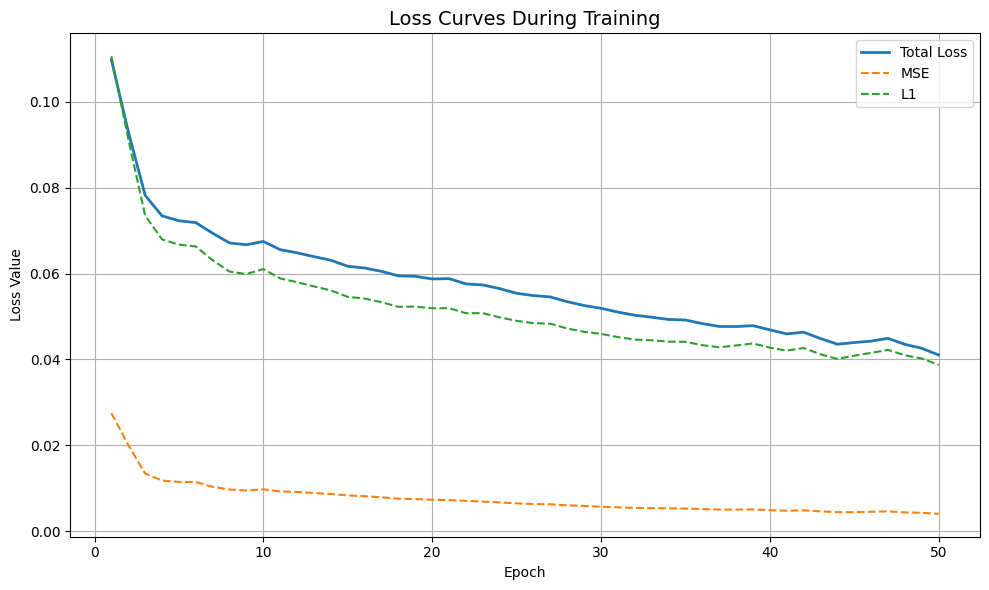

In [66]:
# Plot loss curves
plt.figure(figsize=(10, 6))
epochs = range(1, 51)

plt.plot(epochs, loss_history["total"], label="Total Loss", linewidth=2)
plt.plot(epochs, loss_history["mse"], label="MSE", linestyle="--")
plt.plot(epochs, loss_history["l1"], label="L1", linestyle="--")
plt.plot(epochs, loss_history["ssim"], label="SSIM", linestyle="--")
plt.plot(epochs, loss_history["ms_ssim"], label="MS-SSIM", linestyle="--")

plt.title("Loss Curves During Training", fontsize=14)
plt.xlabel("Epoch")
plt.ylabel("Loss Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt

# Sample data for demonstration (replace with your actual loss_history values)
epochs = range(1, 51)

# Create the subplots
fig, axes = plt.subplots(3, 2, figsize=(12, 10))
axes = axes.flatten()

# Plot each loss component

axes[0].plot(epochs, loss_history["mse"], label="MSE", color="green")
axes[0].set_title("(a) MSE")

axes[1].plot(epochs, loss_history["l1"], label="L1", color="orange")
axes[1].set_title("(b) L1")

axes[2].plot(epochs, loss_history["ssim"], label="SSIM", color="purple")
axes[2].set_title("(c) SSIM")

axes[3].plot(epochs, loss_history["ms_ssim"], label="MS-SSIM", color="blue")
axes[3].set_title("(d) MS-SSIM")

# Hide the 5th subplot (axes[4]) to leave space
fig.delaxes(axes[4])
fig.delaxes(axes[5])

# Add the last plot to a new subplot spanning the bottom row
ax_ms_ssim = plt.subplot2grid((3, 2), (2, 0), colspan=2)
ax_ms_ssim.plot(epochs, loss_history["total"], label="Total Loss", color="red")
ax_ms_ssim.set_title("(e) Total Loss")

# General formatting
for ax in axes[:5]:  # Exclude the deleted one
    if ax:  # Skip None axes
        ax.set_xlabel("Epoch")
        ax.set_ylabel("Loss")
        ax.grid(True)

ax_ms_ssim.set_xlabel("Epoch")
ax_ms_ssim.set_ylabel("Loss")
ax_ms_ssim.grid(True)

plt.tight_layout()

plt.savefig("loss_curves.svg", format="svg")
plt.savefig("loss_curves.png", format="png", dpi=300)
plt.savefig("loss_curves.jpg", format="jpg", dpi=300)

plt.show()

In [56]:
evaluate(model)

Test Metrics:
Average PSNR: 24.0736
Average SSIM: 0.5974
Average MSE: 0.0072
Average MS-SSIM: 0.6448


{'psnr': 24.073620796203613,
 'ssim': 0.5974415888388952,
 'mse': 0.007181033104037245,
 'ms_ssim': 0.6447722845607333}

In [39]:
del model, optimizer
torch.cuda.empty_cache()
gc.collect()

18670

In [ ]:
def show_reconstructions(model, n=5):
    model.eval()
    data = next(iter(train_loader))
    data = data[:n].to(device)
    with torch.no_grad():
        reconstructed = model(data)

    data = data.cpu()
    reconstructed = reconstructed.cpu()
    fig, axs = plt.subplots(4, n, figsize=(n * 2, 6))
    for i in range(n):
        # Original Color Image
        axs[0, i].imshow(data[i, :3].permute(1, 2, 0))
        axs[0, i].axis('off')
        # Original Normal Map
        axs[1, i].imshow(data[i, 3:].permute(1, 2, 0))
        axs[1, i].axis('off')
        # Reconstructed Color Map
        axs[2, i].imshow(reconstructed[i, :3].permute(1, 2, 0))
        axs[2, i].axis('off')
        # Reconstructed Normal Map
        axs[3, i].imshow(reconstructed[i, 3:].permute(1, 2, 0))
        axs[3, i].axis('off')
    axs[0, 0].set_title('Original Color')
    axs[1, 0].set_title('Original Normal')
    axs[2, 0].set_title('Reconstructed Color Map')
    axs[3, 0].set_title('Reconstructed Normal Map')
    plt.tight_layout()
    plt.show()

show_reconstructions(model)